In [1]:
import sys
sys.path.insert(1, sys.path[0]+'/../qiskit/providers/aer/')
sys.path.insert(1, sys.path[0]+'/../')

from matplotlib import pyplot as plt
import numpy as np
from qiskit.quantum_info.operators import Operator
from pulse_new.models.signals import VectorSignal, Constant,  Signal
from pulse_new.models.operator_models import OperatorModel

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

# 1. Basic functionality

In [2]:
r = 1.
w = 1.
signals = [Constant(1.), Signal(1., w)]
operators = [-1j * 2 * np.pi * w * Z/2, -1j * 2 * np.pi * r * X/2]

model = OperatorModel(operators=operators, signals=signals)

Evaluate at a given time.

In [3]:
print(model.evaluate(0.3))
print(model.evaluate(1.))

[[0.-3.14159265j 0.+0.97080552j]
 [0.+0.97080552j 0.+3.14159265j]]
[[0.-3.14159265j 0.-3.14159265j]
 [0.-3.14159265j 0.+3.14159265j]]


Get the drift (terms corresponding to `Constant` coefficients). In this case just the first term.

In [4]:
model.drift

array([[0.-3.14159265j, 0.+0.j        ],
       [0.+0.j        , 0.+3.14159265j]])

# 2. Enter a frame

In this case, we will enter the frame of the drift.

In [5]:
model.frame_operator = model.drift

Evaluate again.

In [6]:
print(model.evaluate(0.1))
print(model.evaluate(0.2))

[[ 0.        +0.j          1.49391608-2.05619909j]
 [-1.49391608-2.05619909j  0.        +0.j        ]]
[[ 0.        +0.j         0.92329092-0.2999954j]
 [-0.92329092-0.2999954j  0.        +0.j       ]]


In the above, the diagonal part of the model is now $0$, as it has been subtracted when entering the frame (which is coincidentally the diagonal). The off-diagonal part, which ordinarily is $-i 2 \pi r X / 2$ multiplied with an oscillating signal, is now rotating between $-iX$ and $-iY$ as a result of being in the frame. We can plot the real and imaginary parts of the first off-diagonal to see this.

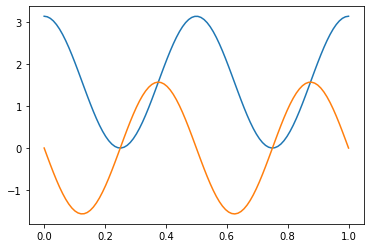

In [7]:
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([model.evaluate(t) for t in t_vals])
offdiag_re = -model_vals[:, 0, 1].real
offdiag_im = -model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re)

In the above, the imaginary part is blue, corresponding to the $X$ operator, and the real part is yellow, corresponding to the $Y$ operator. (Note, usually which is imaginary and which is real is swapped, but in this case our `OperatorModel` is defined as the generator of the Schrodinger equation, so everything has a factor of $-i$.

# 3. Set cutoff frequency

Next, we add a cutoff frequency, which eliminates terms in the model oscillating above a given frequency. The frequencies for a given term are a combination of oscillations due to the chosen frame, as well as oscillations due to signal carrier frequencies.

The classic RWA uses the model we have defined, and sets the cutoff to `2*w`.

In [8]:
model.cutoff_freq = 2*w

We now perform the same plot as above.

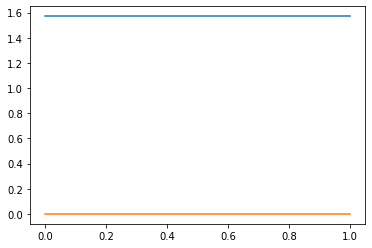

In [9]:
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([model.evaluate(t) for t in t_vals])
offdiag_re = -model_vals[:, 0, 1].real
offdiag_im = -model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re)

Observe, the real part is now constant at $-\pi /2$, which is the average of the oscillation in the previous section (similarly, the imaginary part is constant at the corresponding average of $0$).

# 4. Adding a `signal_mapping`

A `signal_mapping` attribute is meant to be a function that generates the signals from a list of parameters. E.g. for a model involving transfer functions, the action of the transfer functions would be included in `signal_mapping`, and the user would specify the pre-filter signals to the model, which would automatically apply the mapping.

In [10]:
# instantiate without signals but with a signal mapping
r = 1.
w = 1.
operators = [-1j * 2 * np.pi * w * Z/2, -1j * 2 * np.pi * r * X/2]

def signal_map(slope):
    return [Constant(1.), Signal(lambda t: t* slope, w)]

model = OperatorModel(operators=operators, signal_mapping=signal_map)

In [11]:
# now, setting signals will automatically feed the passed values through signal_mapping
model.signals = 1.
print(model._signal_params)
print(model.signals)

1.0


We can plot the X and Y coefficients with no specified frame.

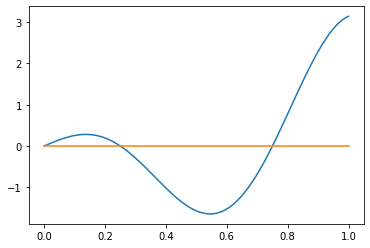

In [12]:
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([model.evaluate(t) for t in t_vals])
offdiag_re = -model_vals[:, 0, 1].real
offdiag_im = -model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re)

The X and Y coefficients in the rotating frame of the drift:

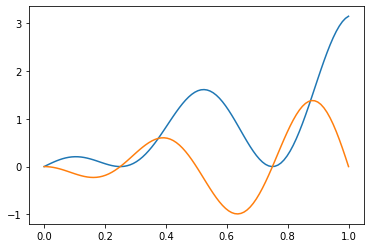

In [13]:
# plot in the drift frame
model.frame_operator = model.drift
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([model.evaluate(t) for t in t_vals])
offdiag_re = -model_vals[:, 0, 1].real
offdiag_im = -model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re)

The X and Y coefficients in the rotating frame after the standard RWA:

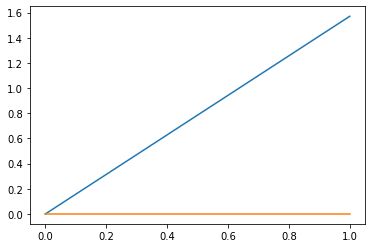

In [14]:
# plot again with cutoff
model.cutoff_freq = 2*w
t_vals = np.linspace(0., 1., 100)
model_vals = np.array([model.evaluate(t) for t in t_vals])
offdiag_re = -model_vals[:, 0, 1].real
offdiag_im = -model_vals[:, 0, 1].imag
plt.plot(t_vals, offdiag_im)
plt.plot(t_vals, offdiag_re)

# 5. Frame helper functionality for states

This class also contains some helper functions for transforming states into/out of frames (and is the motivation/meaning behind the `enter_frame` function earlier). When `OperatorModel` represents the generator $G(t)$ in a differential equation of the form $\dot{y}(t) = G(t) y(t)$, entering a frame $F$ (for $F$ and anti-hermitian operator) corresponds to transforming $y(t) \mapsto z(t) = e^{-Ft}y(t)$, and solving the DE for the variable $z(t)$.

We expect these functions to remain "private" for now - they are part of the `FrameFreqHelper` internal helper class - as they are primarily to be used by solvers.  

The helper function `state_into_frame` performs this mapping at a given time.

In [15]:
# as we are currently in a Z frame, we can see rotation of the following vector when entering a frame
y_in_frame = model._frame_freq_helper.state_into_frame(1.2, np.array([1., 1.]))
print(y_in_frame)

[-0.80901699-0.58778525j -0.80901699+0.58778525j]


In [16]:
# we can convert back out
model._frame_freq_helper.state_out_of_frame(1.2, y_in_frame)

array([1.-8.54340654e-18j, 1.+8.54340654e-18j])

These functions also have additional flags for whether their input/output is specified in the internally stored basis for which the frame is diagonal. The purpose of this is that when solving in a given frame, it makes the most sense to work in a basis in which the frame is diagonal (to save on the cost of evaluating $e^{\pm F t}$) - so the solver will both enter the frame and also change basis.

To see this we need to enter into a frame that isn't already diagonal.

In [17]:
model.frame_operator = -1j* 2 * np.pi * X /2 

We've set $F$ proportional to the $X$ operator. Below we enter the frame at $t = 0$ (and hence no change should occur), but ask for the output to be in the frame basis. Passing a $Z$ eigenstate, we expect to get back an equal superposition of $X$ eigenstates:

In [18]:
model._frame_freq_helper.state_into_frame(0., np.array([1., 0.]), return_in_frame_basis=True)

array([-0.70710678+0.j,  0.70710678+0.j])

And we can verify that this is correct by checking the ordering of the basis elements:

In [19]:
model._frame_freq_helper.frame_basis

array([[-0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j,  0.70710678+0.j]])

We can also specify that both the input and output are in the frame basis - which is natural when a solver is working exclusively in that basis. Here, we ask to enter the frame at $t = 1.1$, but we state that both the input/output are already in the frame basis:

In [20]:
model._frame_freq_helper.state_into_frame(1.1, 
                                          np.array([1., 0.]), 
                                          y_in_frame_basis=True, 
                                          return_in_frame_basis=True)

array([-0.95105652+0.30901699j,  0.        +0.j        ])

As our input was already in a basis state, the result is the same vector collecting a phase corresponding to that eigenvalue:

In [21]:
print(np.exp(-1j * 2 * np.pi * 1.1 / 2))

(-0.9510565162951534+0.30901699437494773j)


Similarly if we pass the other eigenstate:

In [22]:
print(model._frame_freq_helper.state_into_frame(1.1, 
                                                np.array([0., 1.]), 
                                                y_in_frame_basis=True, 
                                                return_in_frame_basis=True))
print(np.exp(1j * 2 * np.pi * 1.1 / 2))

[ 0.        +0.j         -0.95105652-0.30901699j]
(-0.9510565162951534-0.30901699437494773j)


This is consistent with if we specify the corresponding state in the original basis:

In [23]:
y = model._frame_freq_helper.state_into_frame(1.1, 
                                              np.array([1., 1.]) / np.sqrt(2), 
                                              y_in_frame_basis=False, 
                                              return_in_frame_basis=True)
print(y)

[ 0.        +0.j         -0.95105652-0.30901699j]


The `state_out_of_frame` has analagous functionality. We can undo the above transformation (being careful to specify which basis we want the input/output of the function to be in):

In [24]:
model._frame_freq_helper.state_out_of_frame(1.1, 
                                            y, 
                                            y_in_frame_basis=True, 
                                            return_in_frame_basis=False)

array([0.70710678-2.6366832e-18j, 0.70710678-2.6366832e-18j])